In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import numpy as np
from einops import rearrange, repeat
from torch import einsum

In [2]:
class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

torch.Size([5, 9, 94, 32, 64]) dots

In [3]:
dots = torch.randn(5, 9, 94, 32, 64)

In [4]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    return chunk_grid

In [5]:
ChunkGrid(3008, 32)

tensor([[ 0,  0,  0,  ..., 93, 93, 93],
        [ 1,  1,  1,  ..., 92, 92, 92],
        [ 2,  2,  2,  ..., 91, 91, 91],
        ...,
        [91, 91, 91,  ...,  2,  2,  2],
        [92, 92, 92,  ...,  1,  1,  1],
        [93, 93, 93,  ...,  0,  0,  0]])

In [6]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    return chunk_grid

In [7]:
chunkgrid = ChunkGrid(4800, 48)
pareto = torch.distributions.pareto.Pareto(torch.tensor(3.0), torch.tensor(2.0)).sample(chunkgrid.shape)
chunkgrid = chunkgrid - pareto

column = 0
print(chunkgrid[column].topk(384, largest=False).indices.max())
chunkgrid[column].topk(200, largest=False).indices.sort(-1).values

tensor(2976)


tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50,   51,   53,   54,   55,   56,   57,   58,   59,   60,
          61,   62,   63,   64,   65,   66,   68,   70,   72,   73,   74,   75,
          76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
          88,   90,   91,   92,   93,   94,   95,   96,  100,  105,  106,  108,
         111,  112,  116,  118,  119,  121,  122,  123,  128,  129,  130,  132,
         133,  139,  140,  141,  142,  143,  144,  153,  159,  160,  164,  165,
         171,  179,  181,  182,  185,  194,  195,  201,  203,  204,  207,  209,
         211,  212,  213,  218,  220,  222,  223,  228,  240,  241,  244,  246,
         249,  262,  268,  270,  271,  2

In [8]:
chunkgrid.shape

torch.Size([100, 4800])

In [9]:
from matplotlib import pyplot as plt

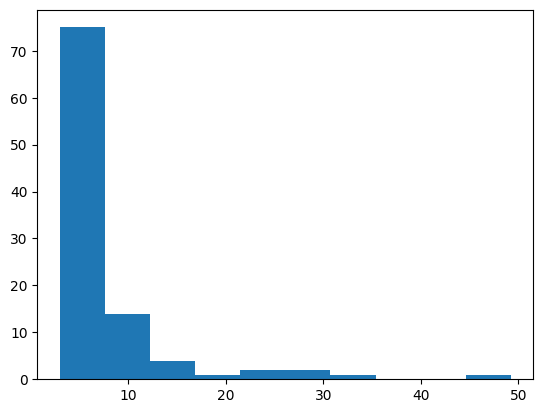

tensor([ 3.0027,  3.0276,  3.0841,  3.0949,  3.1100,  3.1404,  3.1466,  3.1557,
         3.1773,  3.1794,  3.1864,  3.1913,  3.2046,  3.2129,  3.2437,  3.2550,
         3.2893,  3.2930,  3.3105,  3.3153,  3.3707,  3.3853,  3.3963,  3.4286,
         3.4443,  3.4512,  3.4530,  3.4659,  3.4859,  3.5483,  3.5705,  3.6011,
         3.6134,  3.6304,  3.6466,  3.6544,  3.7388,  3.7417,  3.8170,  3.8332,
         3.8828,  3.9243,  4.0115,  4.0353,  4.0695,  4.1411,  4.2320,  4.2701,
         4.3045,  4.3887,  4.4338,  4.4428,  4.4532,  4.5289,  4.8246,  4.9139,
         5.0659,  5.1310,  5.2852,  5.4057,  5.4943,  5.6852,  5.7500,  5.8086,
         6.3482,  6.4263,  6.6473,  6.7006,  6.7580,  6.7968,  6.8142,  6.8534,
         6.9199,  6.9989,  7.4794,  7.7167,  7.7324,  7.9597,  8.0943,  8.1085,
         8.1113,  8.1790,  8.2046,  8.5093,  8.6637,  8.6658,  9.5260,  9.5810,
        10.8826, 13.5426, 14.4840, 14.7551, 15.0706, 19.0224, 21.5217, 24.3253,
        27.8317, 30.5397, 34.8064, 49.21

In [10]:
dist = torch.distributions.pareto.Pareto(3, 2).sample(torch.tensor([100]))
plt.hist(dist)
plt.show()
print(dist.sort(-1).values)

In [11]:
print(chunkgrid[0].topk(40, largest=False).indices.max())
chunkgrid[0].topk(40, largest=False).indices.sort(-1).values


tensor(2976)


tensor([   2,   21,   31,   38,   40,   68,   77,   80,   93,  100,  119,  121,
         129,  142,  182,  201,  220,  240,  249,  273,  281,  308,  348,  352,
         367,  501,  509,  559,  700,  705,  865,  926,  957,  992, 1116, 1230,
        1461, 1673, 2538, 2976])

In [12]:
torch.ones(3, 3).triu(1).bool().repeat_interleave(3, dim=1)

tensor([[False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False]])

In [178]:
class GumbelSigmoid():
    """
    TAKEN FROM: https://github.com/yandexdataschool/gumbel_lstm/blob/master/gumbel_sigmoid.py
    A gumbel-sigmoid nonlinearity with gumbel(0,1) noize
    In short, it's a function that mimics #[a>0] indicator where a is the logit
    
    Explaination and motivation: https://arxiv.org/abs/1611.01144
    
    Math:
    Sigmoid is a softmax of two logits: a and 0
    e^a / (e^a + e^0) = 1 / (1 + e^(0 - a)) = sigm(a)
    
    Gumbel-sigmoid is a gumbel-softmax for same logits:
    gumbel_sigm(a) = e^([a+gumbel1]/t) / [ e^([a+gumbel1]/t) + e^(gumbel2/t)]
    where t is temperature, gumbel1 and gumbel2 are two samples from gumbel noize: -log(-log(uniform(0,1)))
    gumbel_sigm(a) = 1 / ( 1 +  e^(gumbel2/t - [a+gumbel1]/t) = 1 / ( 1+ e^(-[a + gumbel1 - gumbel2]/t)
    gumbel_sigm(a) = sigm([a+gumbel1-gumbel2]/t)
    
    For computation reasons:
    gumbel1-gumbel2 = -log(-log(uniform1(0,1)) +log(-log(uniform2(0,1)) = -log( log(uniform2(0,1)) / log(uniform1(0,1)) )
    gumbel_sigm(a) = sigm([a-log(log(uniform2(0,1))/log(uniform1(0,1))]/t)
    
    
    :param t: temperature of sampling. Lower means more spike-like sampling. Can be symbolic.
    :param eps: a small number used for numerical stability
    :returns: a callable that can (and should) be used as a nonlinearity
    
    """
    def __init__(self, t=0.1, eps=1e-20):
        self.temperature=t
        self.eps=eps
         
    def __call__(self,logits):
        """computes a gumbel sigmoid sample"""
                
        #sample from Gumbel(0, 1)
        uniform1 = torch.rand(logits.shape)
        uniform2 = torch.rand(logits.shape)
        
        noise = -torch.log(torch.log(uniform2 + self.eps)/torch.log(uniform1 + self.eps) +self.eps)
        
        #draw a sample from the Gumbel-Sigmoid distribution
        return ((logits + noise) / self.temperature).sigmoid()

In [174]:
class GumbelSigmoid():
    """
    adapted from: https://github.com/yandexdataschool/gumbel_lstm/blob/master/gumbel_sigmoid.py
    and https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
    """
    def __init__(self, t=0.1, eps=None):
        self.temperature=t
         
    def __call__(self,logits):

        """computes a gumbel sigmoid sample"""
        gumbels = -torch.empty_like(logits).exponential_().log()
        gumbels = (logits + gumbels) / self.temperature
        gumbels = gumbels.sigmoid()
        return gumbels

In [151]:
GumbelSigmoid()

In [179]:
def exists(val):
    return val is not None

class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

class MyopicAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.0,
        max_keep_keys=50,
        chunk_window=3,
        bias=True,
        return_attention=False,
        causal=False,
    ):
        super().__init__()
        self.n_feats = n_feats
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.bias = bias
        self.return_attention = return_attention

        self.causal = causal

        self.scale = head_dim ** -0.5

        self.max_keep_keys = max_keep_keys
        self.W = chunk_window

        self.positional_bias = DynamicPositionBias(
            dim = n_feats,
            heads = n_heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

    def pad_to_window_size(self, x, window_size, axis=3, mask=None):
        """
        Pad the input on two sides to be divisible by `window_size`
        """
        QKV, batch_size, heads, sequence_length, hidden_size = x.shape
        padding_length = (window_size - sequence_length % window_size) % window_size
        padding = torch.zeros(QKV, batch_size, heads, padding_length, hidden_size,
            device=x.device,
            dtype=x.dtype,
        )
        mask = F.pad(mask, (0, padding_length), value=True) 
        return torch.cat([x, padding], axis=axis), padding_length, mask

    def unpad(self, x, padding_length):
        """
        Undo padding.
        """
        if padding_length > 0:
            return x[:, :-padding_length]
        return x

    def ChunkGrid(self, Total_Size, Block_Size):
        Psize = Total_Size // Block_Size
        chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
        #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)) # don't normalize cus it'll stretch the distribution by sequence length
        return chunk_grid    

    def causal_windowed_mask(self, window_number, window_size, device):
        '''
        Create a block diagonal causal mask, to prevent selecting future tokens in the topk key selection
        '''
        return torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)

    def standard_forward(self, qkv, mask):
        query, key, value = qkv
        dots = torch.einsum('bhid,bhjd->bhij', query, key) * self.scale
        positions = self.positional_bias(dots.shape[-1], device=dots.device, dtype=dots.dtype)
        dots += positions
        attn_mask = rearrange(mask, "b n -> b () n ()") * rearrange(mask, "b n -> b () () n")
    
        if self.causal:
            # create a regular causal mask
            causal_mask = torch.ones(dots.shape[-2], dots.shape[-1], device=dots.device).triu(1).bool()
            attn_mask = torch.logical_or(attn_mask, causal_mask)

        
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)
    
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, value)
        return out


    def forward(self, x, mask, return_attention=False):
        assert mask is not None, 'pls wear a mask'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim

        tokeep = min(self.max_keep_keys, N) if self.max_keep_keys != -1 else N # number of keys to keep
        W = min(self.W, N) if self.W != -1 else N # window size

        qkv = rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=H, d=D) # qkv projection

        qkv, pad_n, mask = self.pad_to_window_size(qkv, W, axis=3, mask=mask) # add padding so it's divisible by W
        q, kv = qkv[0], qkv[1:] # separate q and kv, we keep kv together for now as we apply the same operations to both
        
        q = rearrange(q, "b h (n w) d -> b h n w d", w=W)# split q into windows/chunks of size W
      
        q_mask = repeat(rearrange(mask, "b (n w) -> b n w", w=W), "b n w -> b h n w", h=H) # do the same for the mask
            
        kv = repeat(kv, "kv b h n d -> kv b h nw n d", nw=q.shape[2]) # duplicate k and v for total number of windows
        #print(q.shape, kv.shape)
        KV, B, H, NW, N, D = kv.shape

        chunkgrid = self.ChunkGrid(Total_Size=N, Block_Size=W).to(q.device)
        chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous()

        SCALE = torch.tensor(3.0, device=q.device, dtype=q.dtype)
        ALPHA = torch.tensor(2.0, device=q.device, dtype=q.dtype)
        pareto_dist = torch.distributions.pareto.Pareto(SCALE, ALPHA).sample(chunkgrid.shape).to(q.device)
        chunkgrid = chunkgrid - pareto_dist

        chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

        cmask = repeat(mask, 'b n -> kv b h nw n', kv=2, h=H, nw=NW)

        if self.causal:
            causal_mask = self.causal_windowed_mask(window_number=NW, window_size=W, device=q.device)
            cmask = torch.logical_or(cmask, causal_mask)
        
        chunkgrid = chunkgrid.masked_fill(cmask, torch.finfo(q.dtype).max) # max cus we topk in reverse order 

        keep_indices = chunkgrid.topk(k=tokeep, dim=-1, sorted=False, largest=False).indices.sort(dim=-1).values
        KV, B, H, NW, N, D = kv.shape 
        kv = kv.gather(-2, repeat(keep_indices, "kv b h w n -> kv b h w n d", d=D))

        kv_mask = repeat(mask, "b n -> b h nw n", h=H, nw=NW)
     
        kv_mask = kv_mask.gather(-1, keep_indices[0])

        k, v = kv
        # nw (number of windows) = p (in the einsum below)
        dots = einsum("b h n p d, b h n z d -> b h n p z ", q, k) * self.scale # Z is number of chunks in Q, N is max sequence length after dropping
       
        ## positional stuff
        pos_bias = self.positional_bias(N, device=dots.device, dtype=dots.dtype)
        pos_bias = repeat(pos_bias, 'h i j -> b h i j', b = B)
        pos_bias = rearrange(pos_bias, 'b h (n w) j -> b h n w j', w = W)

        keep_indices = repeat(keep_indices, "kv b h nw n -> kv b h nw w n", w=W)[0] 
        pos_bias = pos_bias.gather(-1, keep_indices)
        
        dots = dots + pos_bias

        mask_val = -torch.finfo(dots.dtype).max
        
        qk_mask = rearrange(q_mask, "b h n w -> b h n w ()") * rearrange(kv_mask, "b h w n -> b h w () n")

        if self.causal:
            causal_mask = keep_indices > rearrange(torch.arange(0, N, device=q.device), "(nw w) -> w nw ()", w=NW, nw=W)
            qk_mask = torch.logical_or(qk_mask, causal_mask)
    
        dots.masked_fill_(qk_mask, mask_val)
      
        #print(dots.shape)
        attn = dots.softmax(dim=-1)
      

        normal_attn = self.standard_forward(qkv=qkv, mask=mask)
        normal_attn = rearrange(normal_attn, "b h n d -> b n (h d)")
     

        out = einsum("b h n w z, b h n z d -> b h n w d", attn, v) 

        out = rearrange(out, "b h n w d -> b (n w) (h d)")
   
        
        out = self.unpad(out, pad_n)
        
        out = self.out_proj(out)
     
        return out if not return_attention else (out, attn)

In [200]:
import time
class MyopicAttention3(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.0,
        max_keep_keys=50,
        chunk_window=3,
        bias=True,
        return_attention=False,
        causal=False,
        **kwargs
    ):
        super().__init__()
        self.n_feats = n_feats
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.bias = bias
        self.return_attention = return_attention

        self.causal = causal

        self.scale = head_dim ** -0.5

        self.max_keep_keys = max_keep_keys
        self.W = chunk_window

        self.positional_bias = DynamicPositionBias(
            dim = n_feats,
            heads = n_heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.grid_pos_projection = nn.Linear(1, head_dim*n_heads)
        self.grid_k_projection = nn.Linear(head_dim, head_dim)
        self.grid_activation = nn.ReLU()
        self.grid_scaler_projection = nn.Linear(head_dim, 1)
        self.gumbel_sigmoid = GumbelSigmoid(t=0.1, eps=1e-20)

        self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

    def pad_to_window_size(self, x, window_size, axis=3, mask=None):
        """
        Pad the input on two sides to be divisible by `window_size`
        """
        QKV, batch_size, heads, sequence_length, hidden_size = x.shape
        padding_length = (window_size - sequence_length % window_size) % window_size
        padding = torch.zeros(QKV, batch_size, heads, padding_length, hidden_size,
            device=x.device,
            dtype=x.dtype,
        )
        mask = F.pad(mask, (0, padding_length), value=True) 
        return torch.cat([x, padding], axis=axis), padding_length, mask

    def unpad(self, x, padding_length):
        """
        Undo padding.
        """
        if padding_length > 0:
            return x[:, :-padding_length]
        return x

    def valuegrid(self, total_size, block_size, k):
        n = total_size // block_size
        device, dtype = k.device, k.dtype
        # get time
        t = time.time()
        indices = (rearrange(torch.arange(n, device = device), 'i -> i 1') - rearrange(torch.arange(n, device = device), 'j -> 1 j')) + (n - 1)
        pos = torch.arange(-n + 1, n, device = device, dtype = torch.float32)
        pos = rearrange(pos, '... -> ... 1')
        pos = self.grid_pos_projection(pos)[indices]
    
        pos = pos.repeat_interleave(block_size, dim=1)
        pos = rearrange(pos, "p n (h d) -> () h p n d", h = self.n_heads, d = self.head_dim)
        print("pos", time.time() - t)
    
        # get time
        t = time.time()
        k_voting = self.grid_k_projection(k)
        print("k_voting k projection", time.time() - t)
        k_voting = k_voting + pos
        t = time.time()
        k_voting = self.grid_activation(k_voting)
        print("k_voting activation", time.time() - t)
        t = time.time()
        k_voting = self.grid_scaler_projection(k_voting).squeeze(-1)
        print("k_voting scaler projection", time.time() - t)
        t = time.time()
        k_voting = k_voting / k_voting.sum(dim=-1, keepdim=True)
        print("normalization", time.time() - t)
        t = time.time()
        k_voting = self.gumbel_sigmoid(k_voting)
        print("gumbel sigmoid", time.time() - t)
        return k_voting    

    def causal_windowed_mask(self, window_number, window_size, device):
        '''Create a block diagonal causal mask, to prevent selecting future tokens in the topk key selection'''
        return torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)

    def standard_forward(self, qkv, mask):
        query, key, value = qkv
        dots = torch.einsum('bhid,bhjd->bhij', query, key) * self.scale
        positions = self.positional_bias(dots.shape[-1], device=dots.device, dtype=dots.dtype)
        dots += positions
        attn_mask = rearrange(mask, "b n -> b () n ()") * rearrange(mask, "b n -> b () () n")
    
        if self.causal:
            # create a regular causal mask
            causal_mask = torch.ones(dots.shape[-2], dots.shape[-1], device=dots.device).triu(1).bool()
            attn_mask = torch.logical_or(attn_mask, causal_mask)

        
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)
    
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, value)
        return out


    def forward(self, x, mask, return_attention=False):
        assert mask is not None, 'pls wear a mask'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim

        tokeep = min(self.max_keep_keys, N) if self.max_keep_keys != -1 else N # number of keys to keep
        W = min(self.W, N) if self.W != -1 else N # window size

        qkv = rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=H, d=D) # qkv projection

        qkv, pad_n, mask = self.pad_to_window_size(qkv, W, axis=3, mask=mask) # add padding so it's divisible by W
        q, kv = qkv[0], qkv[1:] # separate q and kv, we keep kv together for now as we apply the same operations to both
        
        q = rearrange(q, "b h (n w) d -> b h n w d", w=W)# split q into windows/chunks of size W
      
        q_mask = repeat(rearrange(mask, "b (n w) -> b n w", w=W), "b n w -> b h n w", h=H) # do the same for the mask
            
        kv = repeat(kv, "kv b h n d -> kv b h nw n d", nw=q.shape[2]) # duplicate k and v for total number of windows
        #print(q.shape, kv.shape)
        KV, B, H, NW, N, D = kv.shape

        # get current time
        t = time.time()
        valuegrid = self.valuegrid(total_size=N, block_size=W, k=kv[0]).to(kv.device)
        valuegrid = repeat(valuegrid, "b h w n -> kv b h w n", kv=2)
        kv = kv * valuegrid.unsqueeze(-1) # maybe just do this for the keys? idk
        print(f'value gridding done in: {time.time() - t:.2f}s')

        cmask = repeat(mask, 'b n -> kv b h nw n', kv=2, h=H, nw=NW)

        if self.causal:
            causal_mask = self.causal_windowed_mask(window_number=NW, window_size=W, device=q.device)
            cmask = torch.logical_or(cmask, causal_mask)
        
        valuegrid = valuegrid.masked_fill(cmask, -torch.finfo(q.dtype).max) 

        # get current time
        t = time.time()
        keep_indices = valuegrid.topk(k=tokeep, dim=-1, sorted=False, largest=True).indices.sort(dim=-1).values
        print(f'topk done in: {time.time() - t:.2f}s')
        KV, B, H, NW, N, D = kv.shape 
       
        # get current time
        t = time.time()
        kv = kv.gather(-2, repeat(keep_indices, "kv b h w n -> kv b h w n d", d=D))
        print(f'gather done in: {time.time() - t:.2f}s')

        kv_mask = repeat(mask, "b n -> b h nw n", h=H, nw=NW)
     
        # get current time
        t = time.time()
        kv_mask = kv_mask.gather(-1, keep_indices[0])
        print(f'kv mask done in: {time.time() - t:.2f}s')

        k, v = kv
        # nw (number of windows) = p (in the einsum below)
        # get current time
        t = time.time()
        dots = einsum("b h n p d, b h n z d -> b h n p z ", q, k) * self.scale # Z is number of chunks in Q, N is max sequence length after dropping
        print(f'dots done in: {time.time() - t:.2f}s')


        ## positional stuff
        # get current time
        t = time.time()
        pos_bias = self.positional_bias(N, device=dots.device, dtype=dots.dtype)
        pos_bias = repeat(pos_bias, 'h i j -> b h i j', b = B)
        pos_bias = rearrange(pos_bias, 'b h (n w) j -> b h n w j', w = W)

        keep_indices = repeat(keep_indices, "kv b h nw n -> kv b h nw w n", w=W)[0] 
        pos_bias = pos_bias.gather(-1, keep_indices)
        
        dots = dots + pos_bias
        print(f'pos bias done in: {time.time() - t:.2f}s')

        mask_val = -torch.finfo(dots.dtype).max
        
        qk_mask = rearrange(q_mask, "b h n w -> b h n w ()") * rearrange(kv_mask, "b h w n -> b h w () n")

        if self.causal:
            causal_mask = keep_indices > rearrange(torch.arange(0, N, device=q.device), "(nw w) -> w nw ()", w=NW, nw=W)
            qk_mask = torch.logical_or(qk_mask, causal_mask)
    
        dots.masked_fill_(qk_mask, mask_val)
      
        #print(dots.shape)
        attn = dots.softmax(dim=-1)
      

        #normal_attn = self.standard_forward(qkv=qkv, mask=mask)
        #normal_attn = rearrange(normal_attn, "b h n d -> b n (h d)")
     

        out = einsum("b h n w z, b h n z d -> b h n w d", attn, v) 

        out = rearrange(out, "b h n w d -> b (n w) (h d)")
   
        
        out = self.unpad(out, pad_n)
        
        out = self.out_proj(out)
     
        return out if not return_attention else (out, attn)

In [203]:
attention = MyopicAttention3(n_feats=216, head_dim=24, n_heads=12, max_keep_keys=256, chunk_window=48, causal=True)

x = torch.ones(10, 5000, 216) + torch.randn(10, 5000, 216) * 0.01
mask = torch.zeros(10, 5000).bool()
mask[0, 0:10] = True
mask[2, 23:45] = True

attn= attention(x, mask)

pos 0.37087130546569824
k_voting k projection 1.5005145072937012
k_voting activation 0.903881311416626
k_voting scaler projection 0.1942126750946045
normalization 0.025990724563598633
gumbel sigmoid 1.5739057064056396
value gridding done in: 8.22s
topk done in: 0.47s
gather done in: 0.08s
kv mask done in: 0.01s
dots done in: 0.22s
pos bias done in: 0.74s


In [119]:
attn

tensor([[[ 0.1762,  0.0375, -0.0757,  ..., -0.4059,  0.0893,  0.2033],
         [ 0.1762,  0.0375, -0.0757,  ..., -0.4059,  0.0893,  0.2033],
         [ 0.2048,  0.0727, -0.0292,  ..., -0.4337,  0.1257,  0.2507],
         ...,
         [ 0.3993,  0.0694, -0.1596,  ..., -0.7297,  0.1368,  0.3698],
         [ 0.4000,  0.0698, -0.1586,  ..., -0.7304,  0.1366,  0.3703],
         [ 0.3991,  0.0694, -0.1587,  ..., -0.7312,  0.1353,  0.3711]],

        [[ 0.2733, -0.0692,  0.0803,  ..., -0.4667,  0.2940,  0.2760],
         [ 0.1897,  0.0028, -0.0534,  ..., -0.4747,  0.1475,  0.1296],
         [ 0.1232,  0.0283, -0.0190,  ..., -0.3945,  0.1204,  0.2007],
         ...,
         [ 0.4019,  0.0690, -0.1576,  ..., -0.7312,  0.1378,  0.3730],
         [ 0.4021,  0.0692, -0.1567,  ..., -0.7305,  0.1368,  0.3733],
         [ 0.4029,  0.0689, -0.1560,  ..., -0.7296,  0.1371,  0.3733]],

        [[ 0.1604, -0.0411,  0.2058,  ..., -0.2483,  0.2510,  0.2636],
         [ 0.1253,  0.0116, -0.0204,  ..., -0

In [35]:
attn.shape

torch.Size([1, 12, 8, 1024, 24])

In [67]:
a = torch.nn.Linear(1, 10)
b = torch.arange(-7.0,7.0)
b

tensor([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

In [130]:
from torch_scatter import scatter

class MyopicAttention2(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.0,
        max_keep_keys=50,
        chunk_window=3,
        bias=True,
        return_attention=False,
        causal=False,
        **kwargs
    ):
        super().__init__()
        self.n_feats = n_feats
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.bias = bias
        self.return_attention = return_attention

        self.causal = causal

        self.scale = head_dim ** -0.5

        self.max_keep_keys = max_keep_keys
        self.W = chunk_window

        self.positional_bias = DynamicPositionBias(
            dim = n_feats,
            heads = n_heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.half_precision_mode = kwargs.get("half_precision_mode", 'float16') # 'float16' or 'bfloat16' or float32

        self.scale = nn.Parameter(torch.tensor(kwargs.get('scale', 3.0), requires_grad=True))
        self.alpha = nn.Parameter(torch.tensor(kwargs.get('alpha', 2.0), requires_grad=True))
        self.distance_multiplier = nn.Parameter(torch.tensor([kwargs.get('distance_multiplier_prior', 1.0)]*n_heads, requires_grad=True))

        self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

    def pad_to_window_size(self, x, window_size, axis=3, mask=None):
        """
        Pad the input on two sides to be divisible by `window_size`
        """
        QKV, batch_size, heads, sequence_length, hidden_size = x.shape
        padding_length = (window_size - sequence_length % window_size) % window_size
        padding = torch.zeros(QKV, batch_size, heads, padding_length, hidden_size,
            device=x.device,
            dtype=x.dtype,
        )
        mask = F.pad(mask, (0, padding_length), value=True) 
        return torch.cat([x, padding], axis=axis), padding_length, mask

    def unpad(self, x, padding_length):
        """
        Undo padding.
        """
        if padding_length > 0:
            return x[:, :-padding_length]
        return x

    def ChunkGrid(self, Total_Size, Block_Size):
        Psize = Total_Size // Block_Size
        chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
        return chunk_grid #* self.distance_multiplier.to(chunk_grid.device)

    def causal_windowed_mask(self, window_number, window_size, device):
        '''
        Create a block diagonal causal mask, to prevent selecting future tokens in the topk key selection
        '''
        return torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)


    def half_precision_if_on_cuda(self, x, is_cuda):
        if not is_cuda:
            return x
        elif self.half_precision_mode == 'float16':
            return x.half()
        elif self.half_precision_mode == 'bfloat16':
            return x.bfloat16()
        else:
            return x
      

    def standard_forward(self, qkv, mask):
        query, key, value = qkv
        dots = torch.einsum('bhid,bhjd->bhij', query, key) * self.scale
        positions = self.positional_bias(dots.shape[-1], device=dots.device, dtype=dots.dtype)
        dots += positions
        attn_mask = rearrange(mask, "b n -> b () n ()") * rearrange(mask, "b n -> b () () n")
    
        if self.causal:
            # create a regular causal mask
            causal_mask = torch.ones(dots.shape[-2], dots.shape[-1], device=dots.device).triu(1).bool()
            attn_mask = torch.logical_or(attn_mask, causal_mask)

        
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)
    
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, value)
        return out


    def forward(self, x, mask, return_attention=False):
        assert mask is not None, 'pls wear a mask'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim

        tokeep = min(self.max_keep_keys, N) if self.max_keep_keys != -1 else N # number of keys to keep
        W = min(self.W, N) if self.W != -1 else N # window size

        qkv = rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=H, d=D) # qkv projection

        qkv, pad_n, mask = self.pad_to_window_size(qkv, W, axis=3, mask=mask) # add padding so it's divisible by W
        q, kv = qkv[0], qkv[1:] # separate q and kv, we keep kv together for now as we apply the same operations to both
        
        q = rearrange(q, "b h (n w) d -> b h n w d", w=W) # split q into windows/chunks of size W
      
        q_mask = repeat(rearrange(mask, "b (n w) -> b n w", w=W), "b n w -> b h n w", h=H) # do the same for the mask
        kv = repeat(kv, "kv b h n d -> kv b h nw n d", nw=q.shape[2]) # duplicate k and v for total number of windows
        
        KV, B, H, NW, N, D = kv.shape

        chunkgrid = self.ChunkGrid(Total_Size=N, Block_Size=W).to(q.device)
        chunkgrid = self.half_precision_if_on_cuda(chunkgrid, q.is_cuda)
        chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous() 
        distance_multiplier = self.half_precision_if_on_cuda(self.distance_multiplier, q.is_cuda).to(q.device)
        distance_multiplier = repeat(self.distance_multiplier, "h -> b h w n", b=B, w=NW, n=N)
        chunkgrid = chunkgrid * distance_multiplier
        

        SCALE = self.scale.to(q.device).to(chunkgrid.dtype)
        ALPHA = self.alpha.to(q.device).to(chunkgrid.dtype)
        pareto_dist = torch.distributions.pareto.Pareto(SCALE, ALPHA).rsample(chunkgrid.shape).to(chunkgrid.device) # rsample so we can backprop
        chunkgrid = chunkgrid - pareto_dist

        chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

        cmask = repeat(mask, 'b n -> kv b h nw n', kv=2, h=H, nw=NW)

        if self.causal:
            causal_mask = self.causal_windowed_mask(window_number=NW, window_size=W, device=q.device)
            cmask = torch.logical_or(cmask, causal_mask)
        
        chunkgrid = chunkgrid.masked_fill(cmask, torch.finfo(chunkgrid.dtype).max) # max cus we topk in reverse order 

        keep_indices = chunkgrid.topk(k=tokeep, dim=-1, sorted=False, largest=False)
        '''
         we want to take half of the keep indices (the ones with the largest vals) and apply a softmax to the values
         then scatter the values with a multiply reduction to the k tensor
         this allows the model to learn which keys to keep using the parametized pareto distribution
         so kinda works like a relu (but not really)
        '''
        sorted_vals_with_indices = keep_indices.values.sort(-1)
        num_to_scatter = tokeep // 4 # number of keys to scatter to kv
        scatter_indices = sorted_vals_with_indices.indices[..., -num_to_scatter:].long() # indices of the keys to scatter
        scatter_indices = repeat(scatter_indices[0], 'b h w n -> b h w n d', d=D)
        scatter_vals = sorted_vals_with_indices.values[..., -num_to_scatter:] # values of the keys to scatter
        scatter_vals = scatter_vals[0].softmax(-1) #* -1 + 1 # softmax but we want the smallest values to be the largest
        scatter_vals = repeat(scatter_vals, 'b h w n -> b h w n d', d=D)
        scatter_vals = scatter_vals * torch.randn(D, device=scatter_vals.device, dtype=scatter_vals.dtype) # add some noise to the values

        print(scatter_vals.shape, 'scatter_vals')
        print(kv.shape, 'kv')

        kv = kv.contiguous() # we need kv to be contigous so we can scatter properly
        kv[0] = scatter(
            src = scatter_vals,
            index = scatter_indices,
            dim = -2,
            out = kv[0].clone(),
            reduce = 'mul'
        )

        ###
        keep_indices = keep_indices.indices.sort(dim=-1).values
        KV, B, H, NW, N, D = kv.shape 
        kv = kv.gather(-2, repeat(keep_indices, "kv b h w n -> kv b h w n d", d=D))

        kv_mask = repeat(mask, "b n -> b h nw n", h=H, nw=NW)
     
        kv_mask = kv_mask.gather(-1, keep_indices[0])

        k, v = kv
        # nw (number of windows) = p (in the einsum below)
        dots = einsum("b h n p d, b h n z d -> b h n p z ", q, k) * self.scale # Z is number of chunks in Q, N is max sequence length after dropping
       
        ## positional stuff
        pos_bias = self.positional_bias(N, device=dots.device, dtype=dots.dtype)
        pos_bias = repeat(pos_bias, 'h i j -> b h i j', b = B)
        pos_bias = rearrange(pos_bias, 'b h (n w) j -> b h n w j', w = W)

        keep_indices = repeat(keep_indices, "kv b h nw n -> kv b h nw w n", w=W)[0] 
        pos_bias = pos_bias.gather(-1, keep_indices)
        
        dots = dots + pos_bias

        mask_val = -torch.finfo(dots.dtype).max
        
        qk_mask = rearrange(q_mask, "b h n w -> b h n w ()") * rearrange(kv_mask, "b h w n -> b h w () n")

        if self.causal:
            causal_mask = keep_indices > rearrange(torch.arange(0, N, device=q.device), "(nw w) -> w nw ()", w=NW, nw=W)
            qk_mask = torch.logical_or(qk_mask, causal_mask)
    
        dots.masked_fill_(qk_mask, mask_val)
      
        #print(dots.shape)
        attn = dots.softmax(dim=-1)
      

        normal_attn = self.standard_forward(qkv=qkv, mask=mask)
        normal_attn = rearrange(normal_attn, "b h n d -> b n (h d)")
     

        out = einsum("b h n w z, b h n z d -> b h n w d", attn, v) 

        out = rearrange(out, "b h n w d -> b (n w) (h d)")
   
        
        out = self.unpad(out, pad_n)
        
        out = self.out_proj(out)
     
        return out if not return_attention else (out, attn)

In [163]:
attention = MyopicAttention3(n_feats=216, head_dim=24, n_heads=12, max_keep_keys=256, chunk_window=128, causal=True)

x = torch.ones(10, 5000, 216) + torch.randn(10, 5000, 216) * 0.01
mask = torch.zeros(10, 5000).bool()
mask[0, 0:10] = True
mask[2, 23:45] = True

attn = attention(x, mask)

value gridding done in: 2.22s


In [96]:
from torch_scatter import scatter

src = torch.arange(1, 11, requires_grad=True, dtype=torch.float32).reshape((2, 5))

index = torch.tensor([[2,2,2,2,2],[1,1,1,1,1]])

out = torch.ones(3, 5, dtype=src.dtype, requires_grad=True)
# Broadcasting in the first and last dim.

out2 = scatter(
    src=src.clone().to(torch.float16),
    index=index.clone().long(),
    dim=0,
    out=out.clone().to(torch.float16),
    reduce='mul'
)

out2


tensor([[ 1.,  1.,  1.,  1.,  1.],
        [ 6.,  7.,  8.,  9., 10.],
        [ 1.,  2.,  3.,  4.,  5.]], dtype=torch.float16,
       grad_fn=<CppNode<ScatterMul>>)

In [241]:
src = torch.arange(1, 11, requires_grad=True, dtype=torch.float32).reshape((2, 5))
index = torch.tensor([[2,2,2,2,2],[1,1,1,1,1]])
out = torch.ones(3, 5, dtype=src.dtype, requires_grad=True)
out = out.scatter(0, index, src, reduce="multiply")
out

tensor([[ 1.,  1.,  1.,  1.,  1.],
        [ 6.,  7.,  8.,  9., 10.],
        [ 1.,  2.,  3.,  4.,  5.]], grad_fn=<NotImplemented>)

In [15]:
num1 = 0
num2 = 100
torch.allclose(attn[1][num1,num2][:99],attn[0][num1,num2][:99])

False

In [16]:
attn[0][num1,num2][:99]

tensor([-0.8768,  0.5403, -0.4982, -0.6676, -0.1726, -0.2841, -0.7748,  1.2937,
         0.0952, -0.1790,  1.2793, -0.0180,  0.9306,  0.0510,  0.3877, -0.3233,
         0.4503,  0.1754, -0.1733, -0.5921,  0.0930, -0.1853,  0.6594, -0.5966,
         0.3983,  1.2907, -1.0663,  0.8151,  0.4143,  0.9949, -0.8028, -0.7665,
         0.3114, -0.3060,  0.2174, -0.0145,  0.5195, -0.0629,  0.4824, -0.2134,
         0.6487, -0.5543, -0.3998,  0.4835,  0.0325, -0.4887,  0.2463,  0.4638,
         0.8298, -0.3127,  0.1380, -0.2188,  0.5023, -0.7221, -0.8195, -0.4364,
         0.8616, -0.3429,  0.1433, -0.4033, -0.3301, -0.0268, -0.0619,  1.1195,
         0.2910, -0.1543,  0.0028, -0.2260,  0.4619, -0.6561, -1.0260,  0.9179,
         0.4099,  0.3758, -0.3285,  0.2757,  0.1249,  0.2334, -0.4744,  0.2244,
         0.1443,  0.5162, -0.4617,  1.6897, -0.0114, -0.1633,  1.4041,  0.0071,
         0.1075, -0.0576, -0.3595,  1.0768, -0.2301,  0.2440, -0.2712, -0.1436,
        -0.4499,  0.0817,  0.1923], grad

In [17]:
attn[1][num1,num2][:99]

tensor([-0.8763,  0.5412, -0.4970, -0.6680, -0.1719, -0.2844, -0.7754,  1.2929,
         0.0941, -0.1780,  1.2803, -0.0186,  0.9319,  0.0527,  0.3864, -0.3259,
         0.4511,  0.1756, -0.1716, -0.5920,  0.0946, -0.1866,  0.6605, -0.5974,
         0.3983,  1.2904, -1.0669,  0.8148,  0.4136,  0.9948, -0.8030, -0.7670,
         0.3114, -0.3058,  0.2181, -0.0146,  0.5198, -0.0632,  0.4835, -0.2136,
         0.6495, -0.5541, -0.3987,  0.4832,  0.0317, -0.4898,  0.2457,  0.4634,
         0.8292, -0.3139,  0.1377, -0.2188,  0.5017, -0.7225, -0.8183, -0.4363,
         0.8627, -0.3435,  0.1434, -0.4036, -0.3294, -0.0279, -0.0622,  1.1187,
         0.2912, -0.1556,  0.0032, -0.2260,  0.4617, -0.6569, -1.0256,  0.9165,
         0.4104,  0.3760, -0.3257,  0.2749,  0.1252,  0.2296, -0.4745,  0.2247,
         0.1442,  0.5181, -0.4622,  1.6930, -0.0105, -0.1656,  1.4024,  0.0040,
         0.1096, -0.0572, -0.3583,  1.0765, -0.2305,  0.2418, -0.2765, -0.1430,
        -0.4499,  0.0819,  0.1923], grad

In [18]:
torch.allclose(attn[0], attn[1])

False

In [19]:
torch.tensor([0,1,2,3,4,5,6]).topk(k=3, sorted=False, largest=False).indices.sort(dim=-1).values

tensor([0, 1, 2])

In [15]:
x = torch.randn(10, 1000, 216)
mask = torch.zeros(10, 1000).bool()

In [ ]:
### OLD CHUNKGRID SHIT
def ChunkGrid(self, Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    return chunk_grid    

chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous()
MEAN = torch.tensor(0, device=q.device, dtype=q.dtype)
STD = torch.tensor(0.125, device=q.device, dtype=q.dtype)
uniform_dist = torch.distributions.normal.Normal(MEAN, STD).sample(chunkgrid.shape).to(q.device)
chunkgrid += uniform_dist
chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

In [35]:
def causal_windowed_mask(window_number, window_size, device):
    mask = torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)
    return mask

In [37]:
causal_windowed_mask(3, 4, device='cpu')

tensor([[False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False]])

In [ ]:
a.indices.sort().values[0, 0, 0, 0]

In [ ]:
torch.tensor(2).unsqueeze(-1).repeat(2).expand(2, 2)

In [ ]:
torch.randn()

In [ ]:
km.shape

In [ ]:
km[0, 0, :, 0, :100].sum(-1)

In [ ]:
km.shape

In [ ]:
(torch.arange(0, 3008).repeat(3008,1) - torch.arange(0, 3008).repeat(3008,1).T).reshape(32, -1, 3008).shape

- duplicated across KV
- each batch, head and Window have a different view of the keys
- 94 is the number of windows i.e 94*32(win size) = 3008 (sequence length)

In [ ]:
kv.shape

In [ ]:
kv[km].reshape(2, 5, 8, 3, -1, 24).shape

In [ ]:
repeat(cg, "W N -> KV B H W N", B=5, H=8, KV=2).shape

In [ ]:
kv.s

In [ ]:
def ChunkGrid(N_BLOCKS, BLOCK_SIZE):
    chunk_grid = (torch.arange(0, N_BLOCKS).repeat(BLOCK_SIZE,1) - torch.arange(0, BLOCK_SIZE).repeat(N_BLOCKS,1).T).repeat_interleave(BLOCK_SIZE, dim=1).abs()
    chunk_grid = chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)
    return chunk_grid

In [ ]:
cg = ChunkGrid(41, 3)
uniform_dist = torch.distributions.uniform.Uniform(0, 1).sample(cg.shape)
cg += uniform_dist
keep_indices = cg.topk(9, dim=-1).indices
keep_mask = torch.zeros_like(cg).scatter_(1, keep_indices, 1).bool()

In [ ]:
cg.shape

In [ ]:
keep_mask